## IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report, accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

## DATA LOADING

In [2]:
# Load dataset
df = pd.read_csv('pinjaman_dataset.csv')

# Menampilkan 5 baris pertama dari dataset
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [3]:
# Menampilkan informasi tentang dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [4]:
# Ubah nama setiap kolom
df.rename(columns={
    'loan_amnt': 'jumlah_pinjaman',
    'term': 'jangka_waktu',
    'int_rate': 'suku_bunga',
    'installment': 'angsuran',
    'grade': 'kelas',
    'sub_grade': 'sub_kelas',
    'emp_title': 'jabatan_pekerjaan',
    'emp_length': 'lama_bekerja',
    'home_ownership': 'kepemilikan_rumah',
    'annual_inc': 'pendapatan_tahunan',
    'verification_status': 'status_verifikasi',
    'issue_d': 'tanggal_penerbitan',
    'loan_status': 'status_pinjaman',
    'purpose': 'tujuan_pinjaman',
    'title': 'judul_pinjaman',
    'dti': 'rasio_hutang_pendapatan',
    'earliest_cr_line': 'garis_kredit_terawal',
    'open_acc': 'akun_terbuka',
    'pub_rec': 'catatan_publik',
    'revol_bal': 'saldo_revolving',
    'revol_util': 'utilisasi_revolving',
    'total_acc': 'total_akun',
    'initial_list_status': 'status_awal_pencatatan',
    'application_type': 'jenis_aplikasi',
    'mort_acc': 'akun_hipotek',
    'pub_rec_bankruptcies': 'kebangkrutan_publik',
    'address': 'alamat'
}, inplace=True)


In [5]:
# Melihat jumlah baris dan kolom
print("Jumlah baris dan kolom:", df.shape)

Jumlah baris dan kolom: (396030, 27)


In [6]:
# Menampilkan statistik deskriptif dari dataset
df.describe()

,jumlah_pinjaman,suku_bunga,angsuran,pendapatan_tahunan,rasio_hutang_pendapatan,akun_terbuka,catatan_publik,saldo_revolving,utilisasi_revolving,total_akun,akun_hipotek,kebangkrutan_publik
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [7]:
# Menampilkan jumlah nilai yang hilang dalam setiap kolom
df.isnull().sum()

jumlah_pinjaman                0
jangka_waktu                   0
suku_bunga                     0
angsuran                       0
kelas                          0
sub_kelas                      0
jabatan_pekerjaan          22927
lama_bekerja               18301
kepemilikan_rumah              0
pendapatan_tahunan             0
status_verifikasi              0
tanggal_penerbitan             0
status_pinjaman                0
tujuan_pinjaman                0
judul_pinjaman              1756
rasio_hutang_pendapatan        0
garis_kredit_terawal           0
akun_terbuka                   0
catatan_publik                 0
saldo_revolving                0
utilisasi_revolving          276
total_akun                     0
status_awal_pencatatan         0
jenis_aplikasi                 0
akun_hipotek               37795
kebangkrutan_publik          535
alamat                         0
dtype: int64

## EDA

In [8]:
df.head()

,jumlah_pinjaman,jangka_waktu,suku_bunga,angsuran,kelas,sub_kelas,jabatan_pekerjaan,lama_bekerja,kepemilikan_rumah,pendapatan_tahunan,...,akun_terbuka,catatan_publik,saldo_revolving,utilisasi_revolving,total_akun,status_awal_pencatatan,jenis_aplikasi,akun_hipotek,kebangkrutan_publik,alamat
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [9]:
df['status_pinjaman'].value_counts().hvplot.bar(
    title="Jumlah Status Pinjaman", xlabel='Status Pinjaman', ylabel='Jumlah', 
    width=500, height=350
)

:Bars   [status_pinjaman]   (count)

Sebagian besar peminjam di dataset berhasil melunasi pinjamannya.

Hanya sebagian kecil yang mengalami gagal bayar (Charged Off).

Hal ini menunjukkan bahwa secara umum, portofolio pinjaman ini memiliki tingkat kelunasan yang cukup baik.

<Axes: >

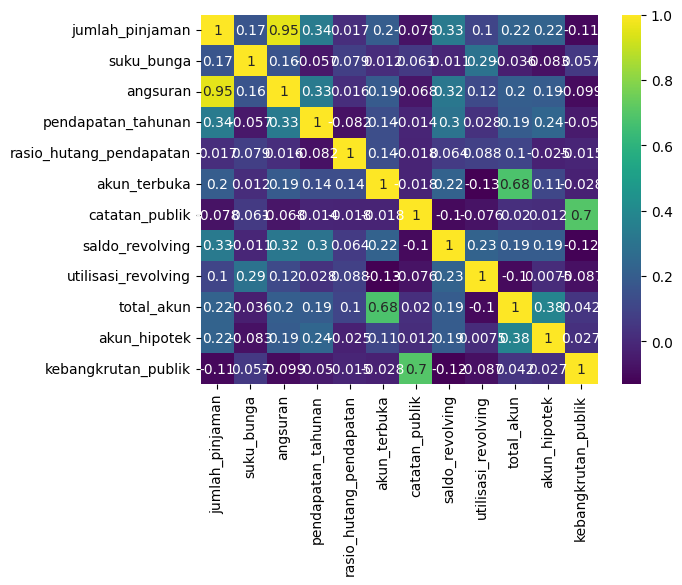

In [10]:
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='viridis')

Ditemukan bahwa korelasi paling kuat dalam dataset terdapat antara variabel jumlah pinjaman (loan_amnt) dan angsuran bulanan (installment). Hal ini logis karena semakin besar jumlah pinjaman, maka besarnya angsuran juga cenderung meningkat. Korelasi tinggi ini mengindikasikan hubungan linier yang kuat dan perlu diperhatikan dalam pemodelan suku bunga.

##### jumlah_pinjaman & angsuran

Text(0.5, 1.0, 'Hubungan antara Angsuran dan Status Pinjaman')

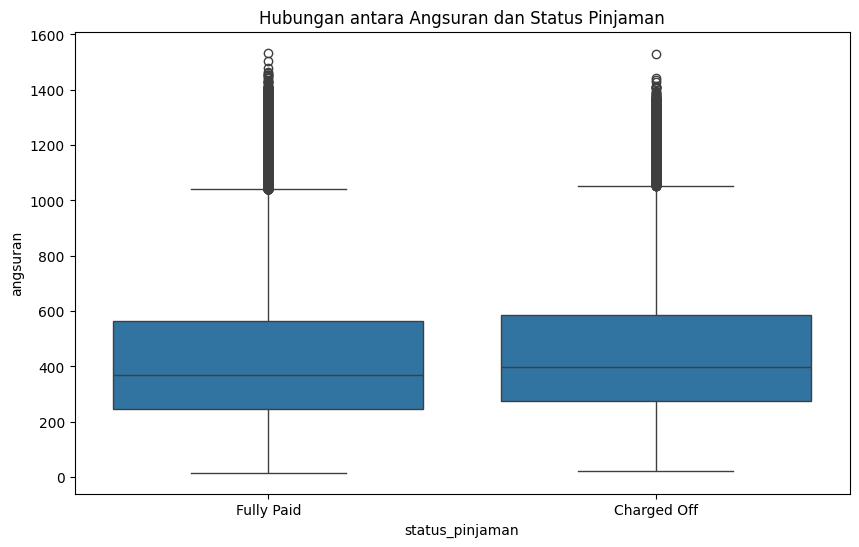

In [11]:
# Visualisasi plot untuk melihat hubungan antara angsuran dan status pinjaman
plt.figure(figsize=(10, 6))
sns.boxplot(x='status_pinjaman', y='angsuran', data=df)
plt.title('Hubungan antara Angsuran dan Status Pinjaman')

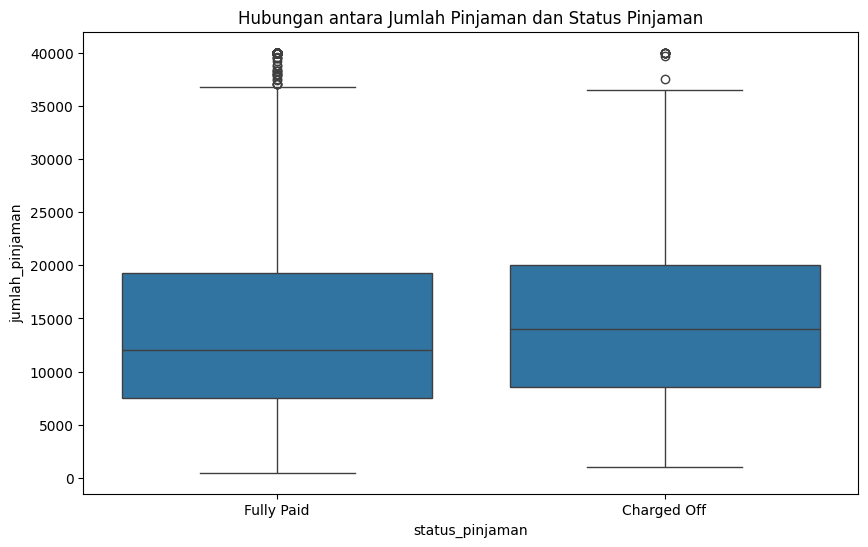

In [12]:
# Visualisasi plot untuk melihat hubungan antara jumlah pinjaman dan status pinjaman
plt.figure(figsize=(10, 6))
sns.boxplot(x='status_pinjaman', y='jumlah_pinjaman', data=df)
plt.title('Hubungan antara Jumlah Pinjaman dan Status Pinjaman')
plt.show()

Terlihat hubungan linier positif yang sangat kuat antara jumlah pinjaman dan besar angsuran. Artinya, semakin besar pinjaman yang diberikan, maka angsuran per bulan cenderung meningkat. Ini konsisten dengan logika finansial bahwa pinjaman besar memerlukan cicilan yang lebih besar.

Hubungan ini mengindikasikan bahwa salah satu dapat digunakan sebagai proxy untuk yang lain dalam pemodelan, tetapi penting untuk mempertimbangkan kontribusi unik masing-masing terhadap suku bunga.

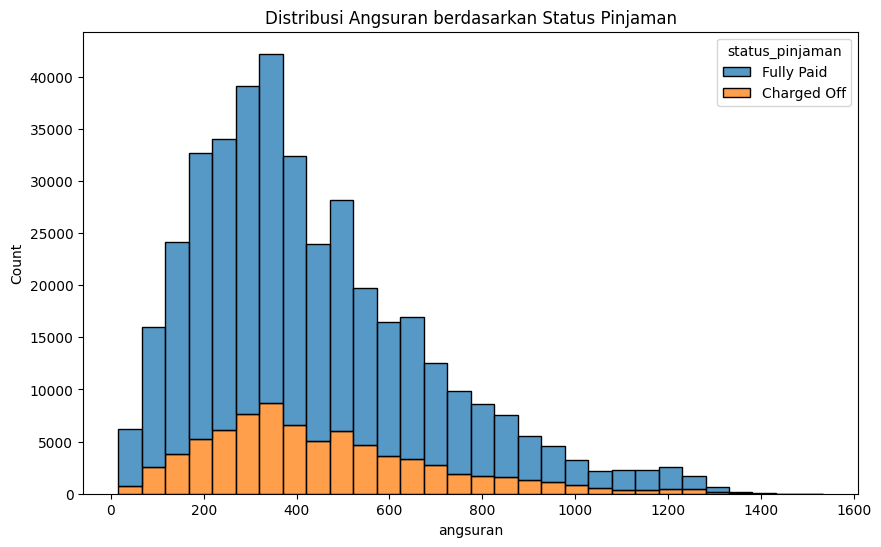

In [13]:
# Visualisasi plot untuk melihat jumlah status pinjaman berdasarkan angsuran
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='angsuran', hue='status_pinjaman', multiple='stack', bins=30)
plt.title('Distribusi Angsuran berdasarkan Status Pinjaman')
plt.show()

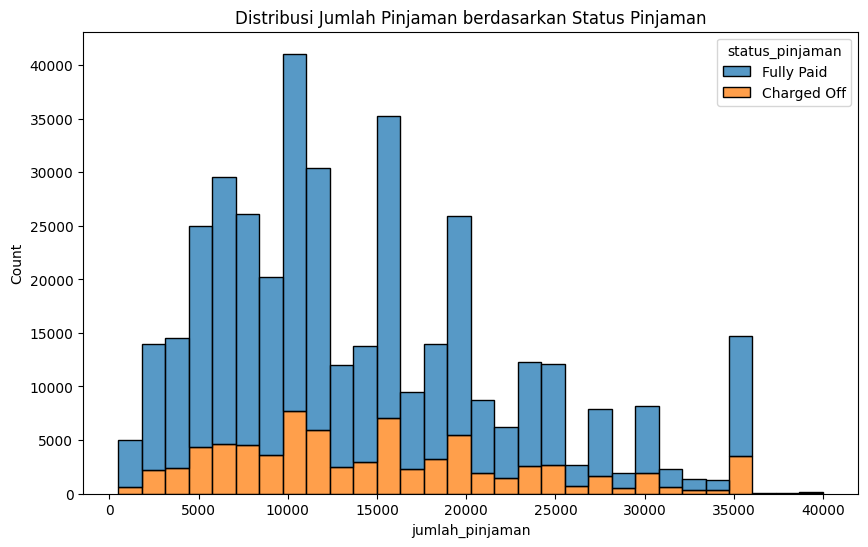

In [14]:
# Visualisasi plot untuk melihat jumlah status pinjaman berdasarkan jumlah pinjaman
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='jumlah_pinjaman', hue='status_pinjaman', multiple='stack', bins=30)
plt.title('Distribusi Jumlah Pinjaman berdasarkan Status Pinjaman')
plt.show()

In [15]:
df.groupby(by='status_pinjaman')['jumlah_pinjaman'].describe()

,count,mean,std,min,25%,50%,75%,max
status_pinjaman,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


- angsuran: Pembayaran bulanan yang harus dibayarkan oleh peminjam jika pinjaman telah disetujui.
- jumlah_pinjaman: Jumlah pinjaman yang diajukan oleh peminjam. Jika suatu saat departemen kredit mengurangi jumlah pinjaman, maka hal tersebut akan tercermin dalam nilai ini.

##### jangka waktu, kepemilikan_rumah, status_verifikasi & tujuan_pinjaman

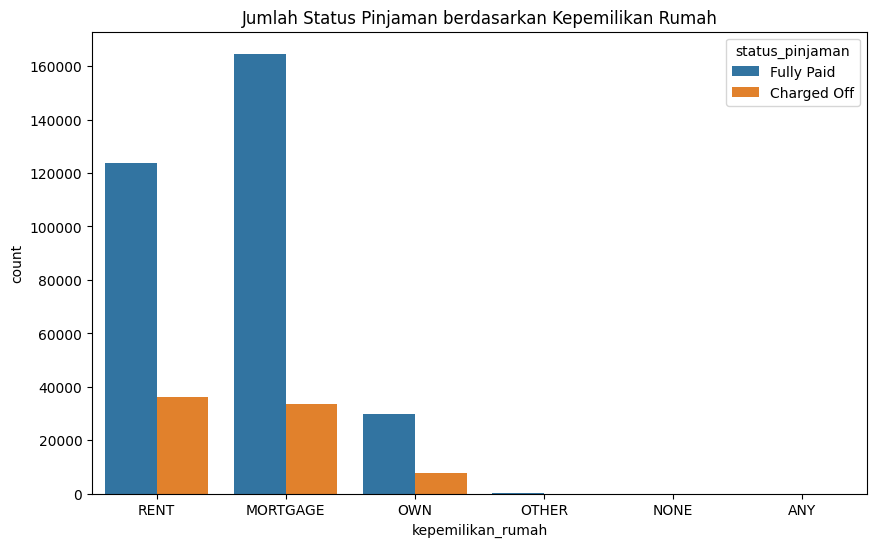

In [16]:
# Visualisasi plot untuk melihat jumlah status pinjaman berdasarkan kepemilikan rumah
plt.figure(figsize=(10, 6))
sns.countplot(x='kepemilikan_rumah', data=df, hue='status_pinjaman')
plt.title('Jumlah Status Pinjaman berdasarkan Kepemilikan Rumah')
plt.show()

Variabel-variabel kategorikal ini menunjukkan pola distribusi yang berbeda-beda terhadap tingkat suku bunga atau jumlah pinjaman.


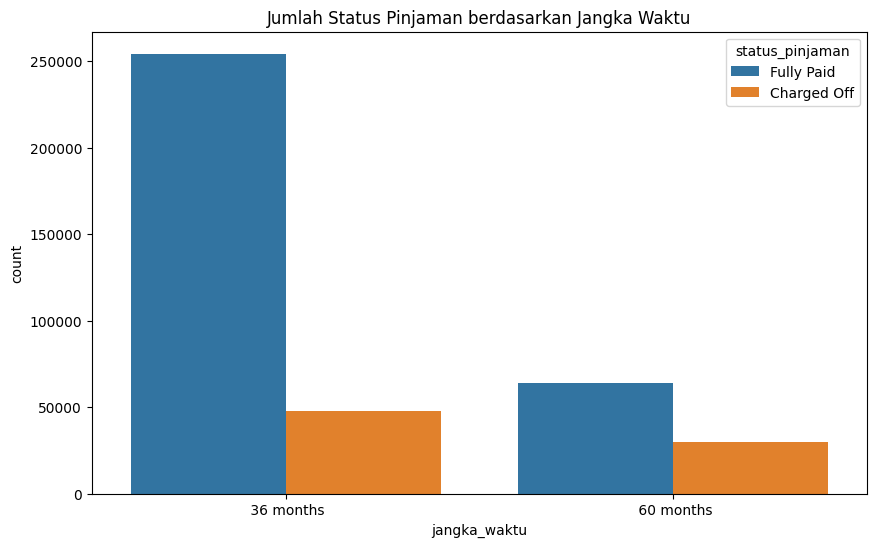

In [17]:
# Visualisasi plot untuk melihat jumlah status pinjaman berdasarkan jangka waktu
plt.figure(figsize=(10, 6))
sns.countplot(x='jangka_waktu', data=df, hue='status_pinjaman')
plt.title('Jumlah Status Pinjaman berdasarkan Jangka Waktu')
plt.show()


jangka waktu pinjaman yang lebih panjang sering kali diikuti oleh suku bunga yang lebih tinggi, menunjukkan adanya risiko tambahan yang diperhitungkan oleh pemberi pinjaman.


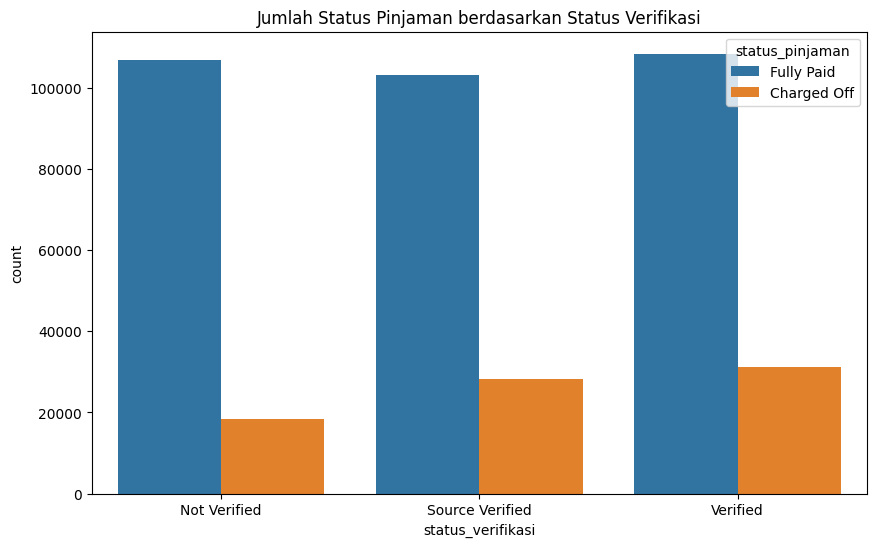

In [18]:
# Visualisasi plot untuk melihat jumlah status pinjaman berdasarkan status verifikasi
plt.figure(figsize=(10, 6))
sns.countplot(x='status_verifikasi', data=df, hue='status_pinjaman')
plt.title('Jumlah Status Pinjaman berdasarkan Status Verifikasi')
plt.show()


Status verifikasi juga tampaknya berperan dalam pengaruh terhadap penilaian risiko.

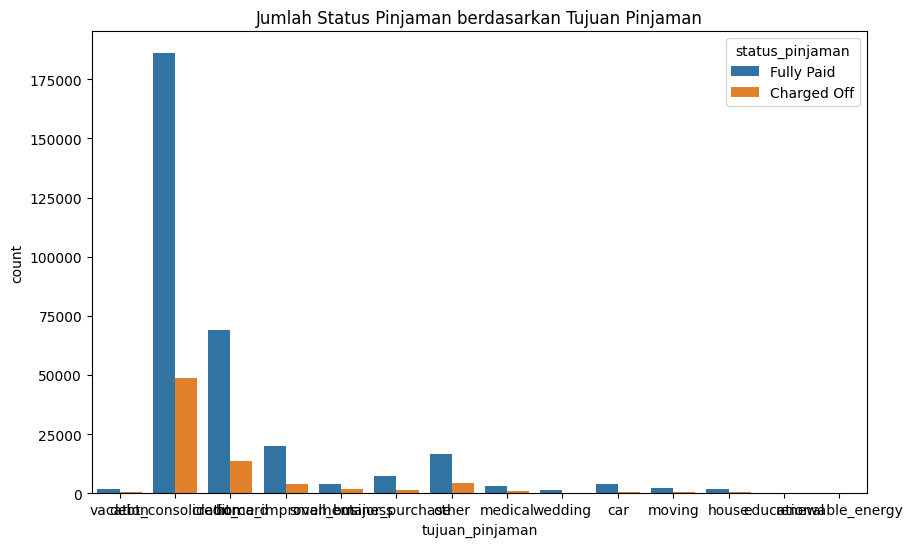

In [19]:
# Visualisasi plot untuk melihat jumlah status pinjaman berdasarkan tujuan pinjaman
plt.figure(figsize=(10, 6))
sns.countplot(x='tujuan_pinjaman', data=df, hue='status_pinjaman')
plt.title('Jumlah Status Pinjaman berdasarkan Tujuan Pinjaman')
plt.show()

- jangka waktu: Jumlah pembayaran pinjaman. Nilai dalam bulan dan dapat berupa 36 atau 60.
- kepemilikan_rumah: Status kepemilikan rumah yang diberikan oleh peminjam saat pendaftaran atau diperoleh dari laporan kredit. Nilai yang tersedia adalah: SEWA, MILIK SENDIRI, HIPOTEK, LAINNYA
- status_verifikasi: Menunjukkan apakah pendapatan diverifikasi oleh LC, tidak diverifikasi, atau jika sumber pendapatan diverifikasi
- tujuan_pinjaman: Kategori yang disediakan oleh peminjam untuk permintaan pinjaman.

##### suku_bunga & pendapatan_tahunan

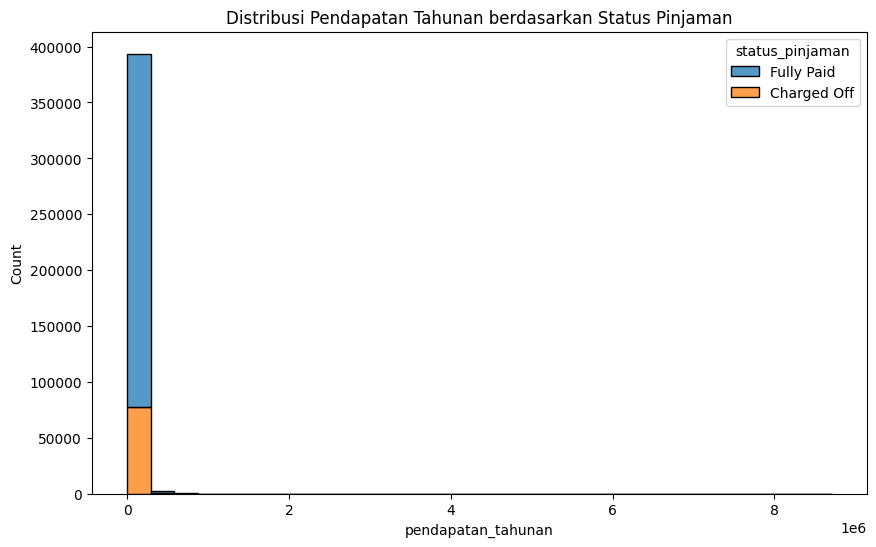

In [20]:
# Visualisasi plot untuk melihat jumlah status pinjaman berdasarkan pendapatan tahunan
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='pendapatan_tahunan', hue='status_pinjaman', multiple='stack', bins=30)
plt.title('Distribusi Pendapatan Tahunan berdasarkan Status Pinjaman')
plt.show()

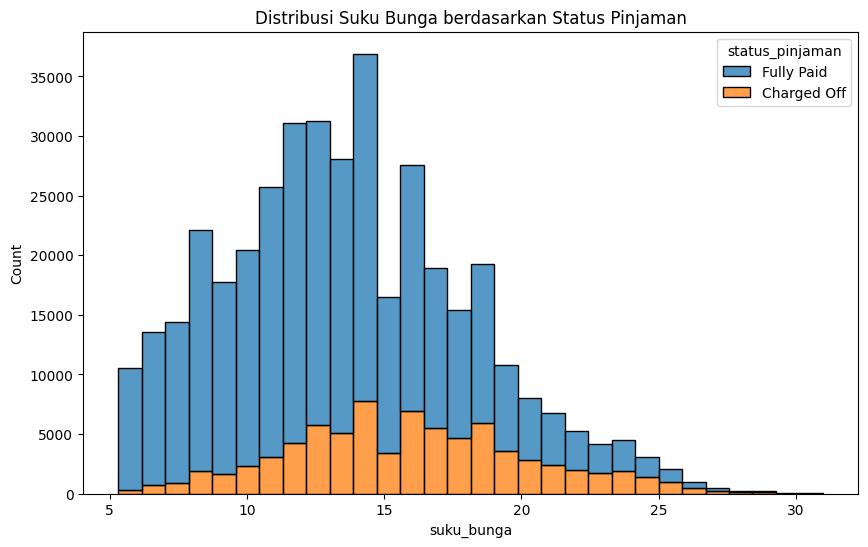

In [21]:
# Visualisasi plot untuk melihat jumlah status pinjaman berdasarkan suku bunga
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='suku_bunga', hue='status_pinjaman', multiple='stack', bins=30)
plt.title('Distribusi Suku Bunga berdasarkan Status Pinjaman')
plt.show()

- suku_bunga : Suku bunga pinjaman
- pendapatan_tahunan : Pendapatan tahunan yang dilaporkan sendiri oleh peminjam saat pendaftaran

##### jabatan_pekerjaan & lama_bekerja

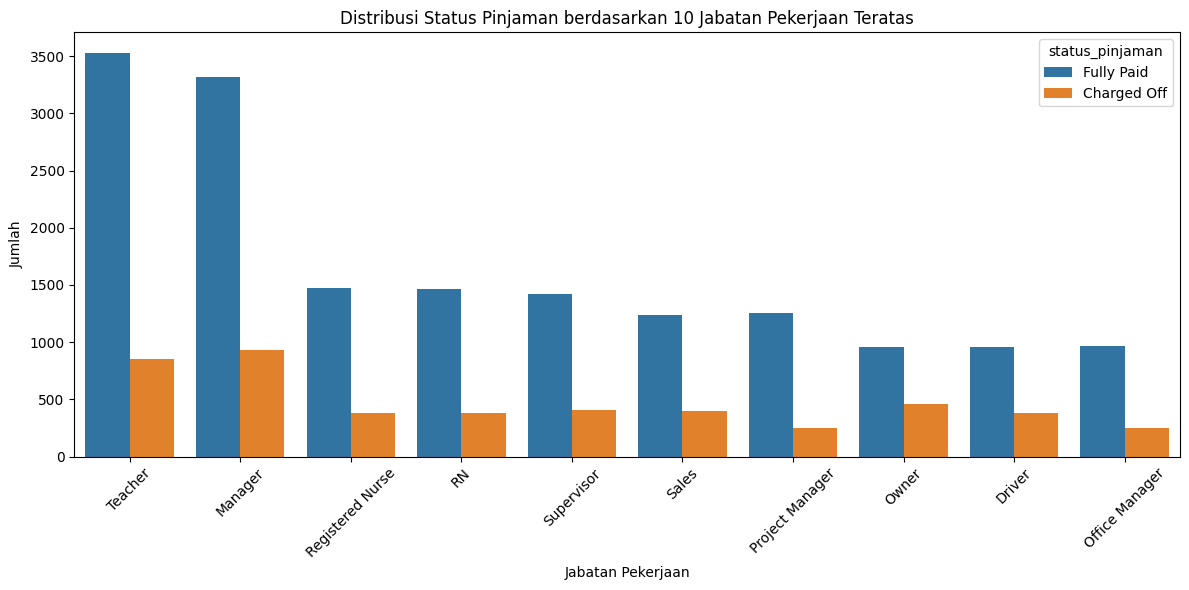

In [22]:
# Visualisasi plot untuk melihat jumlah status pinjaman berdasarkan jabatan pekerjaan
# Ambil 10 jabatan paling umum
top_jobs = df['jabatan_pekerjaan'].value_counts().nlargest(10).index

# Filter data hanya untuk 10 jabatan tersebut
filtered_df = df[df['jabatan_pekerjaan'].isin(top_jobs)]

# Plot dengan countplot
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='jabatan_pekerjaan', hue='status_pinjaman', order=top_jobs)
plt.title('Distribusi Status Pinjaman berdasarkan 10 Jabatan Pekerjaan Teratas')
plt.xlabel('Jabatan Pekerjaan')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

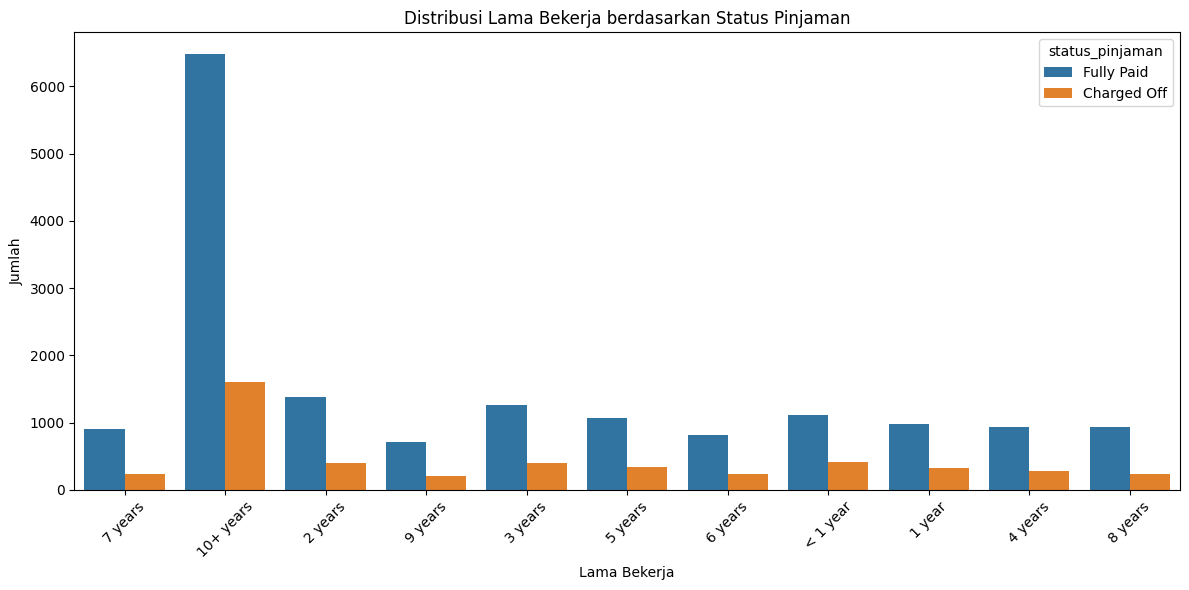

In [23]:
# Visualisasi plot untuk melihat jumlah status pinjaman berdasarkan lama bekerja
# Buat urutan kategorikal untuk lama bekerja
lama_bekerja_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years',
                      '5 years', '6 years', '7 years', '8 years', '9 years',
                      '10+ years', 'n/a']

plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='lama_bekerja', hue='status_pinjaman')
plt.title('Distribusi Lama Bekerja berdasarkan Status Pinjaman')
plt.xlabel('Lama Bekerja')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Keduanya menunjukkan keragaman besar antar kategori, dan berpotensi menunjukkan kestabilan atau risiko peminjam.

Semakin lama seseorang bekerja, secara umum diasumsikan memiliki stabilitas keuangan yang lebih baik, sehingga bisa berdampak pada penetapan bunga pinjaman yang lebih rendah.

- jabatan_pekerjaan : Jabatan yang diberikan oleh Peminjam saat mengajukan pinjaman.
- lama_bekerja : Lama bekerja dalam tahun. Nilai yang dapat dimasukkan adalah antara 0 dan 10 dimana 0 berarti kurang dari satu tahun dan 10 berarti sepuluh tahun atau lebih.

#### Konklusi
Hubungan antar variabel yang ditemukan ini memperlihatkan bahwa suku bunga pinjaman dipengaruhi oleh berbagai faktor — baik numerik maupun kategorikal. Tidak ada satu faktor tunggal yang secara dominan menentukan bunga, melainkan kombinasi dari jumlah pinjaman, durasi pinjaman, profil pekerjaan, dan karakteristik peminjam lainnya.

## DATA PREPROCESSING

- Hapus atau isi data yang hilang.
- Menghapus fitur yang tidak perlu atau berulang.

In [24]:
df

,jumlah_pinjaman,jangka_waktu,suku_bunga,angsuran,kelas,sub_kelas,jabatan_pekerjaan,lama_bekerja,kepemilikan_rumah,pendapatan_tahunan,...,akun_terbuka,catatan_publik,saldo_revolving,utilisasi_revolving,total_akun,status_awal_pencatatan,jenis_aplikasi,akun_hipotek,kebangkrutan_publik,alamat
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60 months,10.99,217.38,B,B4,licensed bankere,2 years,RENT,40000.0,...,6.0,0.0,1990.0,34.3,23.0,w,INDIVIDUAL,0.0,0.0,"12951 Williams Crossing\r\nJohnnyville, DC 30723"
396026,21000.0,36 months,12.29,700.42,C,C1,Agent,5 years,MORTGAGE,110000.0,...,6.0,0.0,43263.0,95.7,8.0,f,INDIVIDUAL,1.0,0.0,"0114 Fowler Field Suite 028\r\nRachelborough, ..."
396027,5000.0,36 months,9.99,161.32,B,B1,City Carrier,10+ years,RENT,56500.0,...,15.0,0.0,32704.0,66.9,23.0,f,INDIVIDUAL,0.0,0.0,"953 Matthew Points Suite 414\r\nReedfort, NY 7..."
396028,21000.0,60 months,15.31,503.02,C,C2,"Gracon Services, Inc",10+ years,MORTGAGE,64000.0,...,9.0,0.0,15704.0,53.8,20.0,f,INDIVIDUAL,5.0,0.0,"7843 Blake Freeway Apt. 229\r\nNew Michael, FL..."


In [25]:
# Melihat persentase missing values
for column in df.columns:
    if df[column].isna().sum() != 0:
        missing = df[column].isna().sum()
        portion = (missing / df.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.2f}%'")

'jabatan_pekerjaan': number of missing values '22927' ==> '5.79%'
'lama_bekerja': number of missing values '18301' ==> '4.62%'
'judul_pinjaman': number of missing values '1756' ==> '0.44%'
'utilisasi_revolving': number of missing values '276' ==> '0.07%'
'akun_hipotek': number of missing values '37795' ==> '9.54%'
'kebangkrutan_publik': number of missing values '535' ==> '0.14%'


Mari kita cek permasalahan missing values di atas

##### jabatan_pekerjaan

In [26]:
df.jabatan_pekerjaan.nunique()

173105

Terdapat banyak sekali jenis jabatan pekerjaan, jadi kita hapus kolom tersebut

In [27]:
df.drop('jabatan_pekerjaan', axis=1, inplace=True)

##### lama_bekerja

In [28]:
df.lama_bekerja.unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [29]:
for year in df.lama_bekerja.unique():
    print(f"{year} years in this position:")
    print(f"{df[df.lama_bekerja == year].status_pinjaman.value_counts(normalize=True)}")
    print('==========================================')

10+ years years in this position:


status_pinjaman
Fully Paid     0.815814
Charged Off    0.184186
Name: proportion, dtype: float64
4 years years in this position:
status_pinjaman
Fully Paid     0.807615
Charged Off    0.192385
Name: proportion, dtype: float64
< 1 year years in this position:
status_pinjaman
Fully Paid     0.793128
Charged Off    0.206872
Name: proportion, dtype: float64
6 years years in this position:
status_pinjaman
Fully Paid     0.810806
Charged Off    0.189194
Name: proportion, dtype: float64
9 years years in this position:
status_pinjaman
Fully Paid     0.79953
Charged Off    0.20047
Name: proportion, dtype: float64
2 years years in this position:
status_pinjaman
Fully Paid     0.806738
Charged Off    0.193262
Name: proportion, dtype: float64
3 years years in this position:
status_pinjaman
Fully Paid     0.804769
Charged Off    0.195231
Name: proportion, dtype: float64
8 years years in this position:
status_pinjaman
Fully Paid     0.80024
Charged Off    0.19976
Name: proportion, dtype: float64
7 

Status pinjaman sangat mirip di semua waktu lama bekerja, jadi bisa kita hapus kolom ini.


In [30]:
df.drop('lama_bekerja', axis=1, inplace=True)

##### judul_pinjaman

In [31]:
df.judul_pinjaman.value_counts().head()

judul_pinjaman
Debt consolidation         152472
Credit card refinancing     51487
Home improvement            15264
Other                       12930
Debt Consolidation          11608
Name: count, dtype: int64

In [32]:
df.tujuan_pinjaman.value_counts().head()

tujuan_pinjaman
debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
Name: count, dtype: int64

Berdasarkan hasil di atas, kolom judul_pinjaman hanya merupakan bagian dari kolom tujuan_pinjaman, jadi tidak diperlukan

In [33]:
df.drop('judul_pinjaman', axis=1, inplace=True)

##### akun_hipotek

In [34]:
df.akun_hipotek.value_counts()

akun_hipotek
0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
26.0         2
32.0         2
31.0         2
23.0         2
34.0         1
28.0         1
30.0         1
Name: count, dtype: int64

In [35]:
df.akun_hipotek.isna().sum()

np.int64(37795)

In [36]:
numeric_df.corr()['akun_hipotek'].drop('akun_hipotek').sort_values().hvplot.barh()

:Bars   [index]   (akun_hipotek)

In [37]:
total_akun_avg = numeric_df.groupby(by='total_akun').mean().akun_hipotek

In [38]:
def fill_akun_hipotek(total_akun, akun_hipotek):
    if np.isnan(akun_hipotek):
        return total_akun_avg[total_akun].round()
    else:
        return akun_hipotek

In [39]:
df['akun_hipotek'] = df.apply(lambda x: fill_akun_hipotek(x['total_akun'], x['akun_hipotek']), axis=1)

##### utilisasi_revolving & kebangkrutan_publik

kedua kolom ini memiliki jumlah kurang dari 0.5 % dari total data, jadi kita dapat menghilangkan kolom ini

In [40]:
# Menghapus kolom yang tidak diperlukan
df.drop(['utilisasi_revolving', 'kebangkrutan_publik'], axis=1, inplace=True)

In [41]:
df.shape

(396030, 22)

#### Variabel Kategori

In [42]:
# Menampilkan kolom bertipe object
print([column for column in df.columns if df[column].dtype == object])

['jangka_waktu', 'kelas', 'sub_kelas', 'kepemilikan_rumah', 'status_verifikasi', 'tanggal_penerbitan', 'status_pinjaman', 'tujuan_pinjaman', 'garis_kredit_terawal', 'status_awal_pencatatan', 'jenis_aplikasi', 'alamat']


##### jangka_waktu

In [43]:
df.jangka_waktu.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [44]:
jangka_waktu_nilai = {' 36 months': 36, ' 60 months': 60}
df['jangka_waktu'] = df.jangka_waktu.map(jangka_waktu_nilai)

##### kelas & sub_kelas

kelas merupakan fitur bagian dari sub_kelas, jadi kita dapat hapus

In [45]:
df.drop('kelas', axis=1, inplace=True)

In [46]:
dummies = ['sub_kelas', 'kepemilikan_rumah', 'status_verifikasi', 'tujuan_pinjaman', 'status_awal_pencatatan', 'jenis_aplikasi']
df = pd.get_dummies(df, columns=dummies, drop_first=True)

##### alamat

menampilkan fitur merekayasa kolom kode pos dari alamat dalam kumpulan data

In [47]:
df.alamat.head()

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: alamat, dtype: object

In [48]:
df['zip_code'] = df.alamat.apply(lambda x: x[-5:])
df.zip_code.value_counts()

zip_code
70466    56985
30723    56546
22690    56527
48052    55917
00813    45824
29597    45471
05113    45402
11650    11226
93700    11151
86630    10981
Name: count, dtype: int64

In [49]:
df = pd.get_dummies(df, columns=['zip_code'], drop_first=True)
df.drop('alamat', axis=1, inplace=True)

##### tanggal_penerbitan

Data dapat bocor, kita tidak akan tahu sebelumnya apakah pinjaman akan diberikan atau tidak ketika menggunakan model kita, jadi secara teori kita tidak akan memiliki issue_date, hilangkan fitur ini.

In [50]:
df.drop('tanggal_penerbitan', axis=1, inplace=True)

##### garis_kredit_terawal

In [51]:
df['garis_kredit_terawal'] = pd.to_datetime(df['garis_kredit_terawal'], format='%b-%Y')
df['garis_kredit_terawal'] = df['garis_kredit_terawal'].dt.year
df.garis_kredit_terawal.nunique()

65

In [52]:
df.garis_kredit_terawal.value_counts()

garis_kredit_terawal
2000    29366
2001    29083
1999    26491
2002    25901
2003    23657
        ...  
1950        3
1951        3
1953        2
1944        1
1948        1
Name: count, Length: 65, dtype: int64

## MODELS & EVALUATE

In [53]:
w_p = df.status_pinjaman.value_counts()[0] / df.shape[0]
w_n = df.status_pinjaman.value_counts()[1] / df.shape[0]

print(f"Weight of positive values {w_p}")
print(f"Weight of negative values {w_n}")

Weight of positive values 0.8038709188697826
Weight of negative values 0.1961290811302174


C:\Users\Pongo\AppData\Local\Temp\ipykernel_27008\3474363646.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w_p = df.status_pinjaman.value_counts()[0] / df.shape[0]
C:\Users\Pongo\AppData\Local\Temp\ipykernel_27008\3474363646.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w_n = df.status_pinjaman.value_counts()[1] / df.shape[0]


In [54]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

print(train.shape)
print(test.shape)

(316824, 79)
(79206, 79)


In [55]:
print(train[train['rasio_hutang_pendapatan'] <= 50].shape)
print(train.shape)

(316798, 79)
(316824, 79)


In [56]:
X_train, y_train = train.drop('status_pinjaman', axis=1), train.status_pinjaman
X_test, y_test = test.drop('status_pinjaman', axis=1), test.status_pinjaman

In [57]:
X_train.dtypes

jumlah_pinjaman       float64
jangka_waktu            int64
suku_bunga            float64
angsuran              float64
pendapatan_tahunan    float64
                       ...   
zip_code_30723           bool
zip_code_48052           bool
zip_code_70466           bool
zip_code_86630           bool
zip_code_93700           bool
Length: 78, dtype: object

In [58]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [60]:
from sklearn.preprocessing import LabelEncoder

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [61]:
def evaluate_nn(true, pred, train=True):
    clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
    
    phase = "Train" if train else "Test"
    print(f"{phase} Result:\n{'=' * 48}")
    print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
    print("_" * 47)
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("_" * 47)
    print(f"Confusion Matrix: \n{confusion_matrix(true, pred)}\n")

def plot_learning_evolution(r):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='Val Loss')
    plt.title('Loss Evolution During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot AUC
    plt.subplot(1, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='Val AUC')
    plt.title('AUC Score Evolution During Training')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = Input(shape=(num_columns,))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    
    x = Dense(num_labels, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    
    return model

In [62]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
9901/9901 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - AUC: 0.8440 - loss: 0.3264 - val_AUC: 0.8997 - val_loss: 0.2682
Epoch 2/20
9901/9901 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - AUC: 0.8759 - loss: 0.2913 - val_AUC: 0.9021 - val_loss: 0.2641
Epoch 3/20
9901/9901 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - AUC: 0.8836 - loss: 0.2854 - val_AUC: 0.9027 - val_loss: 0.2657
Epoch 4/20
9901/9901 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - AUC: 0.8859 - loss: 0.2815 - val_AUC: 0.9027 - val_loss: 0.2626
Epoch 5/20
9901/9901 ━━━━━━━━━━━━━━━━━━━━ 85s 6ms/step - AUC: 0.8874 - loss: 0.2799 - val_AUC: 0.9039 - val_loss: 0.2637
Epoch 6/20
9901/9901 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - AUC: 0.8886 - loss: 0.2780 - val_AUC: 0.9035 - val_loss: 0.2617
Epoch 7/20
9901/9901 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - AUC: 0.8890 - loss: 0.2782 - val_AUC: 0.9030 - val_loss: 0.2679
Epoch 8/20
9901/9901 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step - AUC: 0.8896 - loss: 0.2788 - val_AUC: 0.9042 - val_loss: 0.2627
Epoch 9/20
9901/9901 ━━━━━━━━━━━

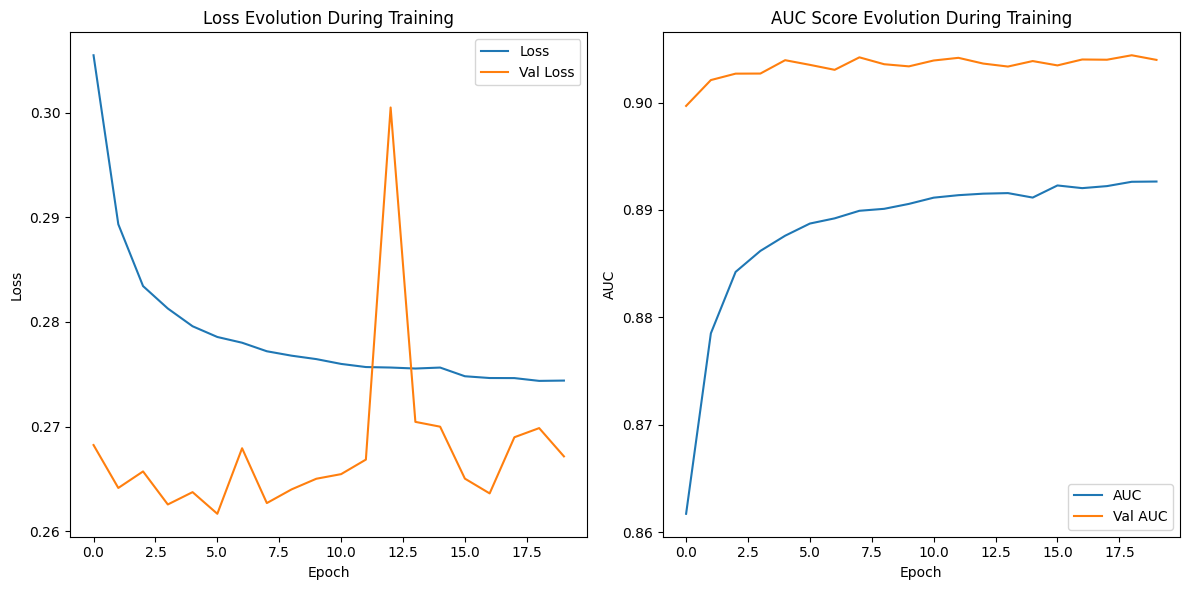

In [63]:
plot_learning_evolution(r)

In [64]:
y_train_pred = model.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), train=True)

9901/9901 ━━━━━━━━━━━━━━━━━━━━ 7s 739us/step
Train Result:
Accuracy Score: 88.92%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0            1.0  accuracy      macro avg   weighted avg
precision      0.940781       0.883672  0.889191       0.912227       0.894865
recall         0.463830       0.992883  0.889191       0.728356       0.889191
f1-score       0.621329       0.935100  0.889191       0.778214       0.873602
support    62096.000000  254728.000000  0.889191  316824.000000  316824.000000
_______________________________________________
Confusion Matrix: 
[[ 28802  33294]
 [  1813 252915]]



In [65]:
y_test_pred = model.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), train=False)

2476/2476 ━━━━━━━━━━━━━━━━━━━━ 2s 729us/step
Test Result:
Accuracy Score: 88.80%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0           1.0  accuracy     macro avg  weighted avg
precision      0.936580      0.882772  0.887988      0.909676      0.893354
recall         0.461706      0.992346  0.887988      0.727026      0.887988
f1-score       0.618507      0.934357  0.887988      0.776432      0.872241
support    15577.000000  63629.000000  0.887988  79206.000000  79206.000000
_______________________________________________
Confusion Matrix: 
[[ 7192  8385]
 [  487 63142]]



In [66]:
from sklearn.metrics import roc_auc_score

scores_dict = {
    'ANNs': {
        'Train': roc_auc_score(y_train, model.predict(X_train)),
        'Test': roc_auc_score(y_test, model.predict(X_test)),
    },
}

9901/9901 ━━━━━━━━━━━━━━━━━━━━ 7s 751us/step
2476/2476 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step


### XGBoost

In [67]:
xgb = XGBClassifier(use_label_encoder=False)

xgb.fit(X_train, y_train)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

c:\Users\Pongo\Documents\Python\ML Terapan\tf-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:06:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Result:
Accuracy Score: 89.48%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0            1.0  accuracy      macro avg   weighted avg
precision      0.938999       0.889722  0.894819       0.914360       0.899380
recall         0.495539       0.992152  0.894819       0.743846       0.894819
f1-score       0.648726       0.938149  0.894819       0.793437       0.881424
support    62096.000000  254728.000000  0.894819  316824.000000  316824.000000
_______________________________________________
Confusion Matrix: 
 [[ 30771  31325]
 [  1999 252729]]

Test Result:
Accuracy Score: 88.89%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0           1.0  accuracy     macro avg  weighted avg
precision      0.917580      0.885650  0.888923      0.901615      0.891930
recall         0.478141      0.989486  0.888923      0.733813      0.888923
f1-score       0.628682      0.934693  0.888923      0.781

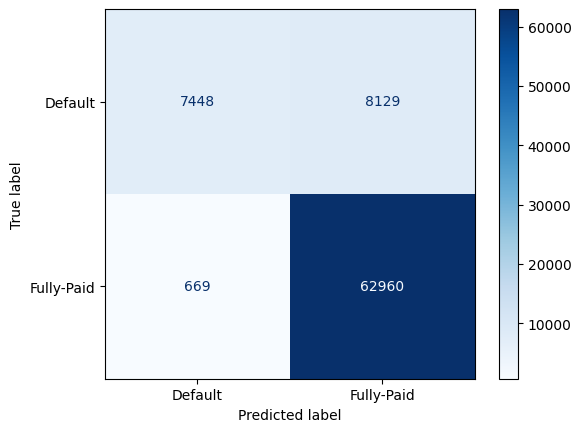

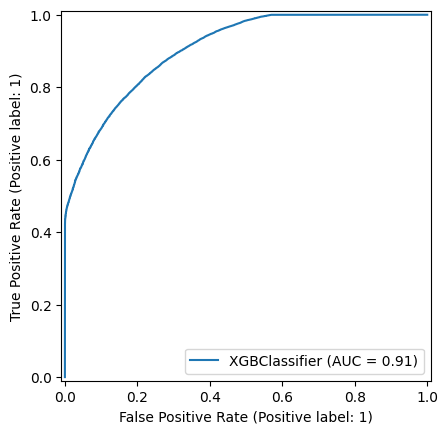

In [68]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(xgb, X_test, y_test)

In [69]:
scores_dict['XGBoost'] = {
        'Train': roc_auc_score(y_train, xgb.predict(X_train)),
        'Test': roc_auc_score(y_test, xgb.predict(X_test)),
    }

### Random Forest

In [70]:
rf = RandomForestClassifier(n_estimators=100)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0            1.0  accuracy      macro avg   weighted avg
precision      1.000000       0.999992  0.999994       0.999996       0.999994
recall         0.999968       1.000000  0.999994       0.999984       0.999994
f1-score       0.999984       0.999996  0.999994       0.999990       0.999994
support    62096.000000  254728.000000  0.999994  316824.000000  316824.000000
_______________________________________________
Confusion Matrix: 
 [[ 62094      2]
 [     0 254728]]

Test Result:
Accuracy Score: 88.85%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0           1.0  accuracy     macro avg  weighted avg
precision      0.949467      0.882074  0.888455      0.915770      0.895328
recall         0.457148      0.994044  0.888455      0.725596      0.888455
f1-score       0.617151      0.934718  0.888455      0.77

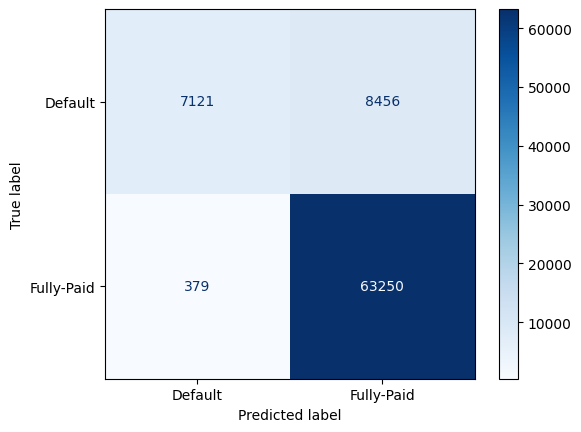

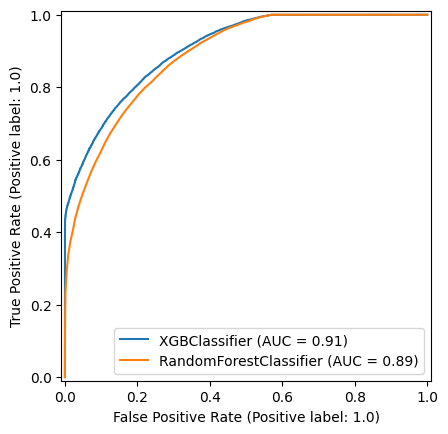

In [71]:
disp = ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Default', 'Fully-Paid'])

disp = RocCurveDisplay.from_estimator(xgb, X_test, y_test)
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=disp.ax_)

In [72]:
scores_dict['Random Forest'] = {
        'Train': roc_auc_score(y_train, rf.predict(X_train)),
        'Test': roc_auc_score(y_test, rf.predict(X_test)),
    }

In [73]:
ml_compare = {
    'Random Forest': rf, 
    'XGBoost': xgb, 
    'ANNs': model
}

for model in ml_compare:
    print(f"{model.upper():{30}} roc_auc_score: {roc_auc_score(y_test, ml_compare[model].predict(X_test)):.3f}")

RANDOM FOREST                  roc_auc_score: 0.726
XGBOOST                        roc_auc_score: 0.734
2476/2476 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
ANNS                           roc_auc_score: 0.904


In [74]:
scores_df = pd.DataFrame(scores_dict)
scores_df.hvplot.barh(
    width=500, height=400, 
    title="ROC Scores of ML Models", xlabel="ROC Scores", 
    alpha=0.4, legend='top'
)

:Bars   [index,Variable]   (value)